# LonLat bins statistic

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
#from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from math import ceil
from m2lib22.cstes import labels, zarr_dir

plt.rcParams.update({'font.size':15})

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

<Client: 'tcp://10.148.1.70:54697' processes=0 threads=0, memory=0 B>

## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [3]:
dl=5
min_coloc_bin = 50

#PDFs
zarr = os.path.join(zarr_dir, f"pdf_lonlat_bin{dl}_sentinel_saral_gps.zarr")
dss = xr.open_zarr(zarr).persist()
#Mean var std rms
zarr = os.path.join(zarr_dir, f"stat_lonlat_bin{dl}_lim{min_coloc_bin}_sentinel_saral_gps.zarr")
ds = xr.open_zarr(zarr).persist()


Exception ignored in: <generator object sync.<locals>.f at 0x2aab01535430>
Traceback (most recent call last):
  File "/home1/datahome/mdemol/.miniconda3/envs/m2env/lib/python3.8/site-packages/distributed/utils.py", line 349, in f
    result = yield future
KeyboardInterrupt: 


KeyboardInterrupt: 

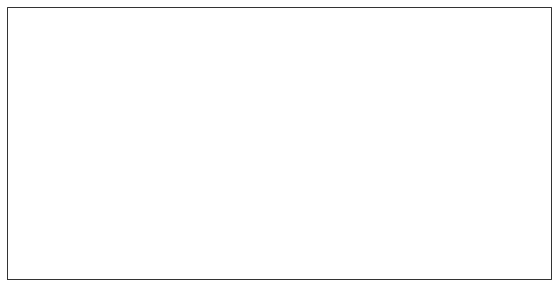

In [4]:
#import matplotlib.ticker as mticker

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ds.nb_coloc_bins.plot(x='lon_bin', y='lat_bin', cmap='viridis', levels=10, ax=ax, vmin=min_coloc_bin, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')
#gl.xlabels_top = False
#gl.ylabels_left = False
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER

fig.suptitle(f'Number of colocalisation per bins of {dl}°')

In [5]:
ds

<xarray.Dataset>
Dimensions:                                                         (
                                                                     id_comb: 36,
                                                                     lat_bin: 35,
                                                                     lon_bin: 71)
Coordinates:
  * id_comb                                                         (id_comb) <U44 ...
  * lat_bin                                                         (lat_bin) float64 ...
  * lon_bin                                                         (lon_bin) float64 ...
Data variables: (12/926)
    mean_alti_adt_g_grad_x                                          (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_alti_adt_oceantide_dac_g_grad_x                            (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_alti_adt_oceantide_g_grad_x                                (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_alti_denoised_g_grad_x                                     (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_alti_g_grad_x                                              (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    mean_aviso_alti_adt_g_grad_x                                    (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    ...                                                              ...
    var_sum_co_denoised_es_cstrio_z15_alti_x                        (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_denoised_es_cstrio_z15_drifter_x                     (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_es_cstrio_z0_alti_x                                  (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_es_cstrio_z0_drifter_x                               (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_es_cstrio_z15_alti_x                                 (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>
    var_sum_co_es_cstrio_z15_drifter_x                              (lon_bin, lat_bin) float64 dask.array<chunksize=(71, 35), meta=np.ndarray>

## Ploting functions

In [5]:
def plot_stat_lonlat(variables, ds=1, cmap='viridis', title =1 , cmap_label =1 ,fig_title=1,**kwargs):
    lv = len(variables)
    if isinstance(variables[0],str):
        variables = [ds[v] for v in variables]
        if isinstance(ds, int) : 
            assert False, 'give dataset'
    nrows = ceil(lv/2)
    ncols = 2
    if lv == 1:
        nrows = 1
        ncols = 1
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,nrows*4))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    if lv !=1:
        axs=axs.flatten()
    else : axs = [axs]

    #Loop over all of the variables
    for i in range(lv):

            # Contour plot
            if cmap_label != 1:
                variables[i].assign_attrs({'long_name':cmap_label[i]}).plot(x='lon_bin', y='lat_bin', cmap=cmap, ax=axs[i],**kwargs)

            else : 
                variables[i].plot(x='lon_bin', y='lat_bin', cmap=cmap, ax=axs[i], **kwargs)
            
            # Title each subplot with the name of the model
            if title != 1:
                axs[i].set_title(title[i], fontsize=14)

            # Draw the coastines for each subplot
            axs[i].coastlines()
            axs[i].add_feature(cfeature.LAND)
            #gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
            #          linewidth=1, color='gray', alpha=0.5, linestyle=':')
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=1, color='gray', alpha=0.5, linestyle=':', xlabel_style = {'color': 'w'}, ylabel_style = {'color': 'w'})
            gl.xlabels_top = False
            gl.ylabels_right = False
    if isinstance(fig_title, str):
        fig.suptitle(fig_title)
    fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
    # Delete the unwanted axes
    if lv !=1:
        for i in np.arange(lv,nrows*2):
            fig.delaxes(axs[i])

In [8]:
def plot_ms_lonlat(ds, id_, title=1,):
    dic = ds['ms_sum_'+id_].attrs
    acc = 'ms_'+dic['acc']
    cor = 'ms_'+dic['coriolis']
    ggrad = 'ms_'+dic['ggrad']
    wd = 'ms_'+dic['wind']
    lettre = ['(a)','(b)','(c)','(d)','(e)']
    ggrad_tick = ds[ggrad].attrs['long_name'].replace('ms[',r'').replace(']','').replace('altimatchup','aviso').replace('driftermatchup','aviso')
    w = ds[wd].attrs['long_name'].replace('ms[',r'').replace(']','').split(' from')
    wd_tick = ' from'.join(w)
    ticks = [r'$d_tu$', r'$-fv$', ggrad_tick, wd_tick]
    
    #S
    S = ds['ms_sum_'+id_]
    title = [r'$\langle S^2\rangle$']
    plot_stat_lonlat([S], title=[cstes.lettres[0]], cmap_label = title,)#, fig_title = id_)

    # S-x/S
    Sx = [ds['ms_exc_acc_' + id_]/S, ds['ms_exc_coriolis_' + id_]/S, ds['ms_exc_ggrad_' + id_]/S, ds['ms_exc_wind_' + id_]/S]
    title = [lettre[i] + '\n'+r'$x =$'+ticks[i] for i in range(len(ticks))]
    cmap_label=[r'$\langle S_{-x}^2\rangle/\langle S^2\rangle$']*len(Sx)
    plot_stat_lonlat(Sx, title=title, cmap_label=cmap_label, cmap='RdYlBu_r', vmin=0.5, vmax=1.5)#, fig_title = id_)
    
    #x/S
    x = [ds[acc]/S,ds[cor]/S, ds[ggrad]/S, ds[wd]/S]
    title = [lettre[i] + '\n'+r'$x =$'+ticks[i] for i in range(len(ticks))]
    cmap_label=[r'$\langle x^2\rangle/\langle S^2\rangle$']*len(Sx)
    plot_stat_lonlat(x, title=title, cmap_label=cmap_label, cmap='RdYlBu_r', vmin=0, vmax=2)#,  fig_title = id_)

    #x+S-x/S
    x = [(ds['ms_exc_acc_' + id_]+ds[acc])/S,(ds['ms_exc_coriolis_' + id_]+ds[cor])/S,(ds['ms_exc_ggrad_' + id_]+ds[ggrad])/S, (ds['ms_exc_wind_' + id_]+ds[wd])/S,]
    title = [lettre[i] + '\n'+r'$x =$'+ticks[i] for i in range(len(ticks))]
    cmap_label=[r'$(\langle S_{-x}^2\rangle +\langle x^2\rangle)/\langle S^2\rangle$']*len(Sx)
    plot_stat_lonlat(x, title=title, cmap_label=cmap_label, cmap='RdYlBu_r', vmin=0, vmax=2)#,  fig_title = id_)


In [8]:
cstes.lettres[0]

'(a)'

## Mean values

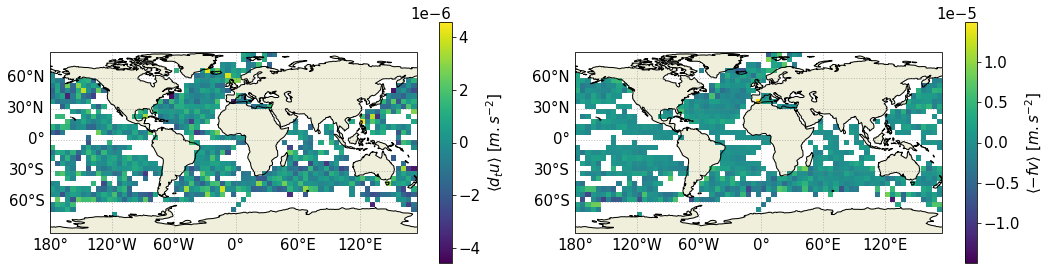

In [9]:
variables=['mean_drifter_acc_x','mean_drifter_coriolis_x',]
plot_stat_lonlat(variables, ds)

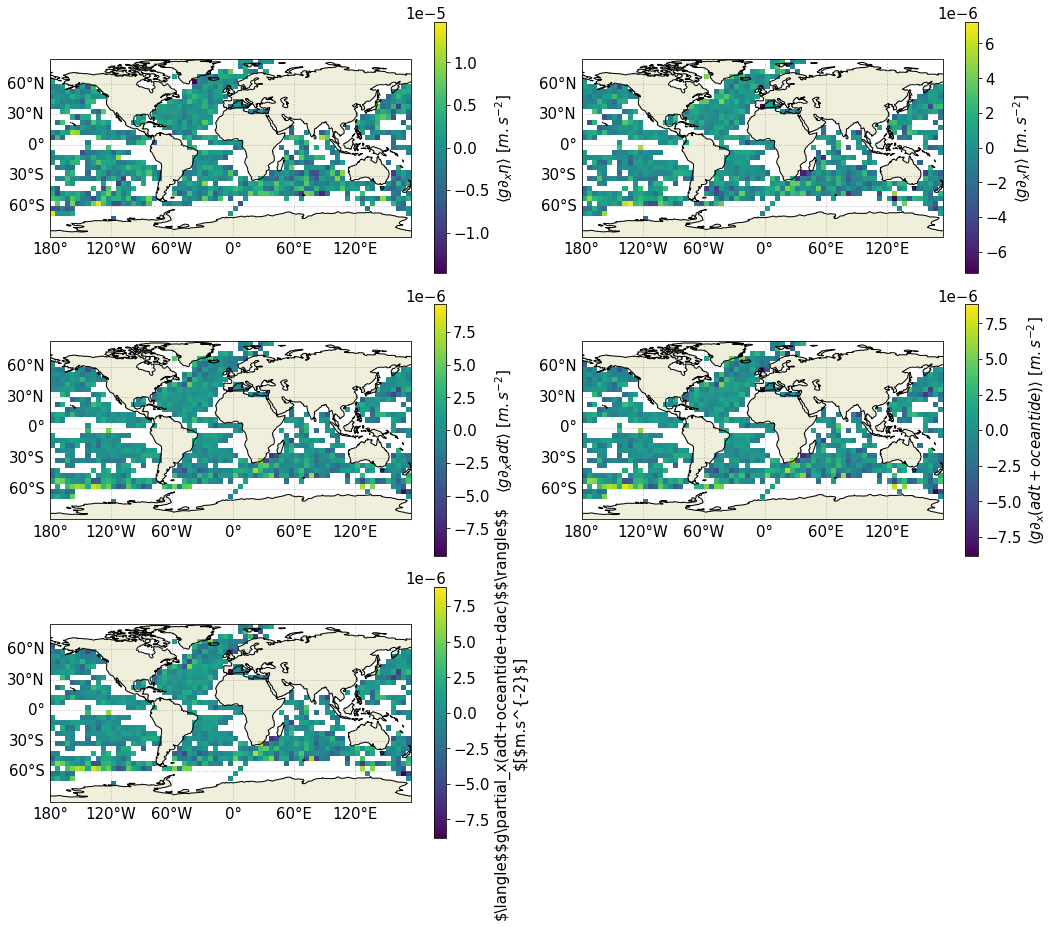

In [10]:
variables=['mean_alti_g_grad_x','mean_alti_denoised_g_grad_x','mean_alti_adt_g_grad_x','mean_alti_adt_oceantide_g_grad_x','mean_alti_adt_oceantide_dac_g_grad_x']
plot_stat_lonlat(variables, ds)

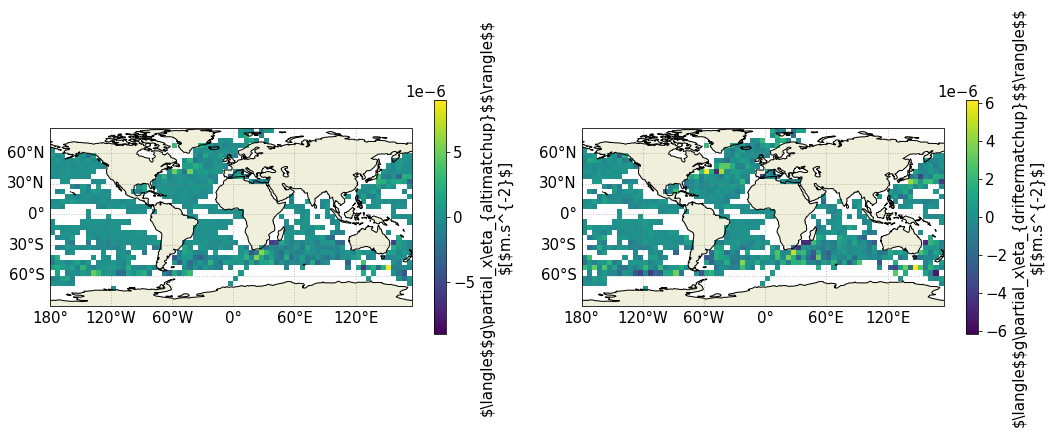

In [11]:
variables=['mean_aviso_alti_g_grad_x','mean_aviso_drifter_g_grad_x']
plot_stat_lonlat(variables, ds)

## Mean square $\langle --^2\rangle$

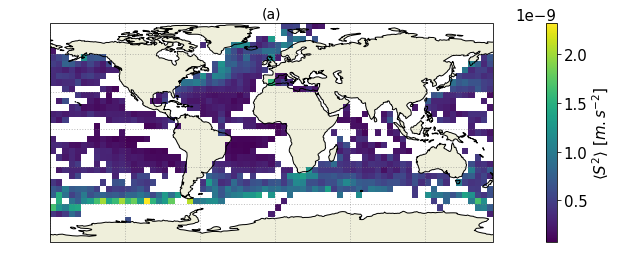

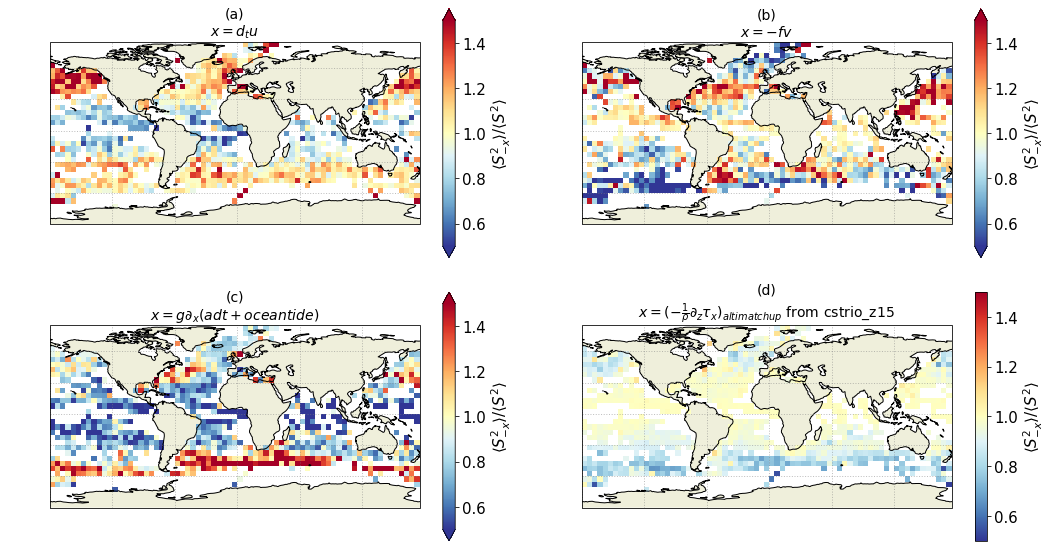

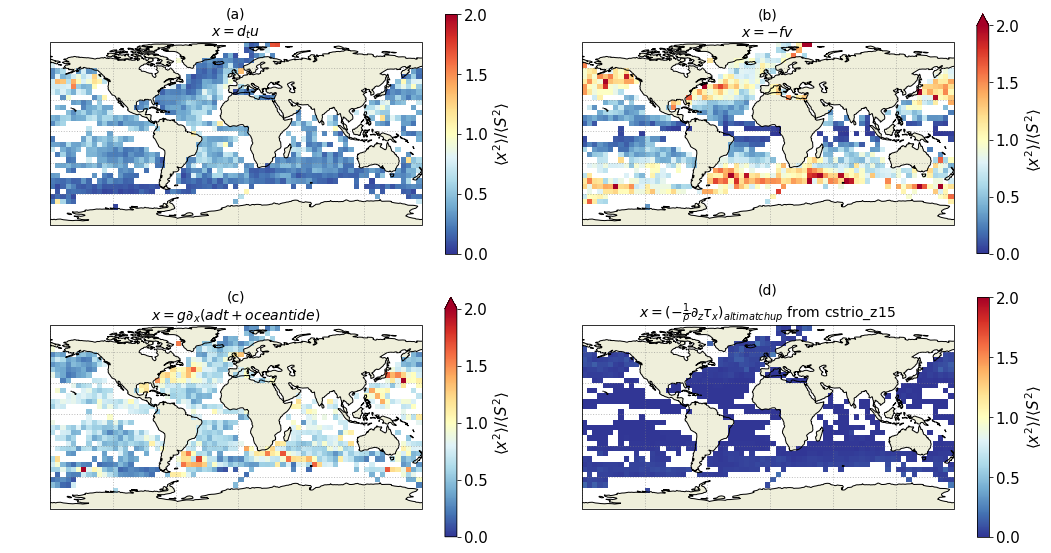

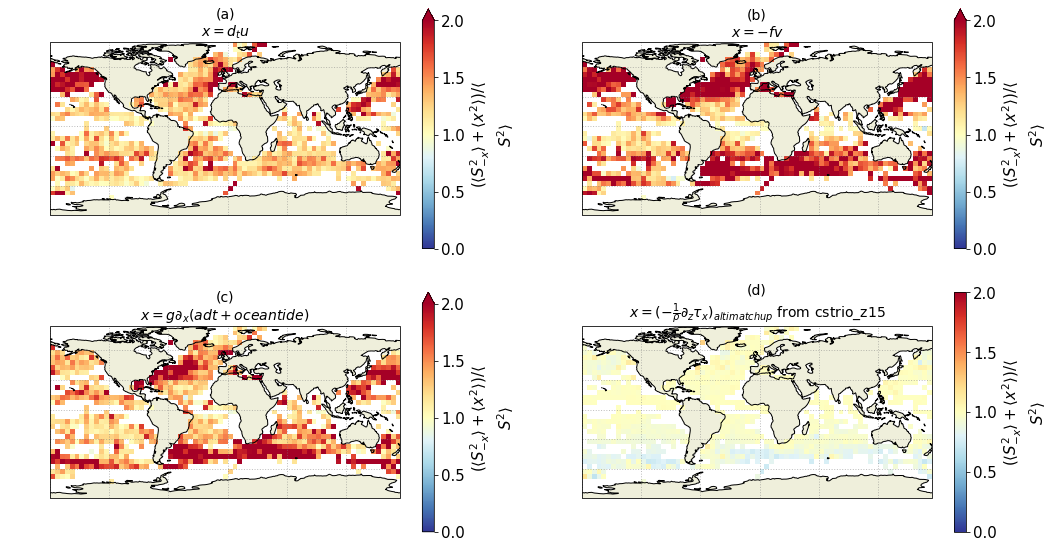

In [9]:
plot_ms_lonlat(ds, id_ = 'co_adt_oceantide_es_cstrio_z15_alti_x')

In [67]:
#MODIFIED FOR POSTER
def plot_stat_lonlat(variables, ds=1, cmap='viridis', title =1 , cmap_label =1 ,fig_title=1,**kwargs):
    lv = len(variables)
    if isinstance(variables[0],str):
        variables = [ds[v] for v in variables]
        if isinstance(ds, int) : 
            assert False, 'give dataset'
    nrows = ceil(lv/2)
    ncols = 2
    if lv == 1:
        nrows = 1
        ncols = 1
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,nrows*4))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    if lv !=1:
        axs=axs.flatten()
    else : axs = [axs]

    #Loop over all of the variables
    for i in range(lv):

            # Contour plot
            if cmap_label != 1:
                a = variables[i].assign_attrs({'long_name':cmap_label[i]}).plot(x='lon_bin', y='lat_bin', cmap=cmap, ax=axs[i],**kwargs)

            else : 
                a = variables[i].plot(x='lon_bin', y='lat_bin', cmap=cmap, ax=axs[i], **kwargs)
            
            # Title each subplot with the name of the model
            if title != 1:
                axs[i].set_title(title[i], fontsize=14, color='w')

            # Draw the coastines for each subplot
            axs[i].coastlines()
            axs[i].add_feature(cfeature.LAND)
            #gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
            #          linewidth=1, color='gray', alpha=0.5, linestyle=':')
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=1, color='gray', alpha=0.5, linestyle=':', xlabel_style = {'color': 'w'}, ylabel_style = {'color': 'w'})
            gl.xlabels_top = False
            gl.ylabels_right = False
            
    if isinstance(fig_title, str):
        fig.suptitle(fig_title, color='w')
    fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
    # Delete the unwanted axes
    if lv !=1:
        for i in np.arange(lv,nrows*2):
            fig.delaxes(axs[i])
    return fig

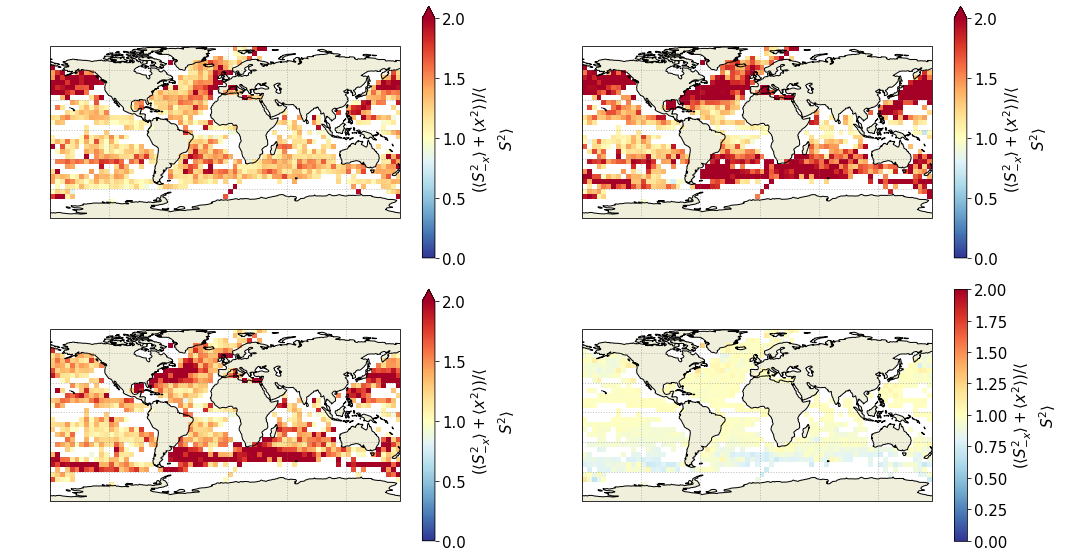

In [71]:
#MODIFIED FOR POSTER
def plot_ms_lonlat(ds, id_, title=1,):
    dic = ds['ms_sum_'+id_].attrs
    acc = 'ms_'+dic['acc']
    cor = 'ms_'+dic['coriolis']
    ggrad = 'ms_'+dic['ggrad']
    wd = 'ms_'+dic['wind']
    lettre = ['(a)','(b)','(c)','(d)','(e)']
    ggrad_tick = ds[ggrad].attrs['long_name'].replace('ms[',r'').replace(']','').replace('altimatchup','aviso').replace('driftermatchup','aviso')
    w = ds[wd].attrs['long_name'].replace('ms[',r'').replace(']','').split(' from')
    wd_tick = ' from'.join(w)
    ticks = [r'$d_tu$', r'$-fv$', ggrad_tick, wd_tick]
    
    #S
    S = ds['ms_sum_'+id_]
    # S-x/S
    Sx = [ds['ms_exc_acc_' + id_]/S, ds['ms_exc_coriolis_' + id_]/S, ds['ms_exc_ggrad_' + id_]/S, ds['ms_exc_wind_' + id_]/S]

    #x+S-x/S
    x = [(ds['ms_exc_acc_' + id_]+ds[acc])/S,(ds['ms_exc_coriolis_' + id_]+ds[cor])/S,(ds['ms_exc_ggrad_' + id_]+ds[ggrad])/S, (ds['ms_exc_wind_' + id_]+ds[wd])/S,]
    title = [r'$x =$'+ticks[i] for i in range(len(ticks))]
    cmap_label=[r'$(\langle S_{-x}^2\rangle +\langle x^2\rangle)/\langle S^2\rangle$']*len(Sx)
    return plot_stat_lonlat(x, title=title, cmap_label=cmap_label, cmap='RdYlBu_r', vmin=0, vmax=2)#,  fig_title = id_)
fig = plot_ms_lonlat(ds, id_ = 'co_adt_oceantide_es_cstrio_z15_alti_x')
path = '/home1/datahome/mdemol/m2_2022/images/lonlat.png'
fig.patch.set_facecolor('None')
fig.savefig(path, dpi=250)

In [42]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


In [69]:
pwd

'/home1/datahome/mdemol/m2_2022/sandbox'